In [19]:
import numpy as np
import matplotlib.pyplot as plt
import math

## LEGGERE UN FILE E COPIARE DATI INCOLONNATI

In [2]:
redshift, distanza, sigma = np.loadtxt('Super.txt', unpack = True)

## FARE UN GRAFICO CON ERROR-BAR

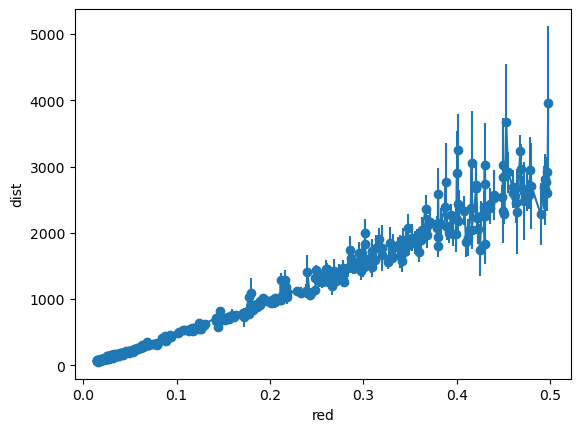

In [3]:
fig, ax = plt.subplots()
ax.errorbar(redshift, distanza, yerr=sigma, marker = 'o') #sulle x redshift, sulle y la distanza ed errori sigma
ax.set_xlabel('red');
ax.set_ylabel('dist');

## ESEGUIRE FIT DEI DATI SU PIU MODELLI

In [4]:
from iminuit import Minuit #importo minuit, che fa la minimizzazione e mi da i parametri del fit
from iminuit.cost import LeastSquares #importo metodo minimi quadrati

In [5]:
def distance_linear (z, H):
    c = 3e5
    return c*z/H

def distance_quad (z, H, q):
    c = 3e5
    return c/H * (z + 0.5 * z ** 2 * (1-q))

In [6]:
#least squares necessita delle x, delle y, dell'errore e della funzione per il fit
#minuit necessita di least squares e dell'inizializzazione delle costanti della funzione
#ho i dati X e Y, sigma definito, voglio fare un fit dei dati utilizzando la funzione f  

##innanzitutto applico i minimi quadrati sui dati con la funzione
least_squares = LeastSquares(redshift, distanza, sigma, distance_linear)
##poi inizializzo le costanti della funzione con stime iniziali 
H = 1
##successivamente utilizzo minuit, che mi fornisce stime sui parametri del fit e altro
fit = Minuit(least_squares, H)
fit.migrad()
fit.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 841.3 (χ²/ndof = 2.1)      │              Nfcn = 74               │
│ EDM = 5.75e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ H    │   63.85   │   0.23    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────┐
│   │      H │
├───┼────────┤
│ H │ 0.0545 │
└───┴────────┘

In [7]:
least_squares2 = LeastSquares(redshift, distanza, sigma, distance_quad) 
 
fit2 = Minuit(least_squares2, H = 1, q = 1)
fit2.migrad()
fit2.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 368.9 (χ²/ndof = 0.9)      │              Nfcn = 196              │
│ EDM = 4.33e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ H    │   70.3    │    0.4    │            │            │         │         │       │
│ 1 │ q    │   -0.41   │   0.07    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       H       q │
├───┼─────────────────┤
│ H │   0.187  -0.025 │
│ q │  -0.025 0.00511 │
└───┴─────────────────┘

In [8]:
#STAMPO I MINIMI di Q^2 trovati
print(fit.fval) 
print(fit2.fval)

841.2764482318939
368.8556129126936


## FARE GRAFICO COMPARATIVO E STAMPARE IL VALORE DELLA COSTANTE CHE APPARTIENE AL FIT MIGLIORE

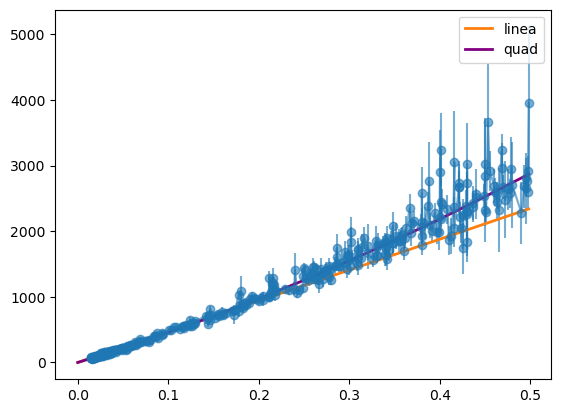

In [17]:
z = np.linspace(0, np.max(redshift), 1000)
                
fig,ax = plt.subplots()
ax.errorbar(redshift, distanza, yerr = sigma, alpha = 0.6, marker = 'o')
ax.plot(z, distance_linear(z, fit.values), label ='linea', linewidth = 2)
ax.plot(z, distance_quad(z, *fit2.values), label = 'quad', linewidth = 2, color = 'purple')
ax.legend();

In [18]:
from scipy.stats import chi2

H_fit_best = 0
p_value_finale = 0
modelli = [fit, fit2]
count = 0

#Comparo il P-value dei due modelli e scelgo il parametro ricavato dal modello col P-value maggiore

for mod in modelli:
    p_value = 1. - chi2.cdf(mod.fval, df = mod.ndof) 

    if p_value > p_value_finale and p_value < 0.95:
        p_value_finale = p_value
        H_fit_best = mod.values['H']
        count += 1

print(f'valore di H stimato: {H_fit_best}')

valore di H stimato: 70.29302846435435


## FARE UN TOY PER DETERMINARE IL VALORE DI q = (2/3 * Om) - 1, il valore medio di Om ed errori, MEDIANA ED ESTREMI DELL'INTERVALLO DI q

In [19]:
#il parametro q (comparso nel secondo modello) ha una costante Om da stimare.
#devo generare q tramite gaussiana con teo lim centrale

from myrand import rand_TCL_ms

Ntoys = 200

Om = []

#devo ricavare la media di q e sigma dal fit precedente (secondo modello)
q = modelli[count].values['q']  #count sarebbe il modello migliore stimato sopra
delta_q = modelli[count].errors['q']

for i in range(Ntoys):
    qt = rand_TCL_ms (q, delta_q, N_sum = 50)
    Om.append (2/3 * (qt + 1))

Om.sort() #per trovare mediana di omega

print(f'mediana è {Om[int(len(Om) * 0.5)]:.4f}')  #:.4f indica il numero di decimali
print(f'valore compreso tra {Om[int(len(Om) * 0.1)]} e {Om[int(len(Om) * 0.9)]}')




mediana è 0.3939
valore compreso tra 0.3272787126028885 e 0.4561552275655433
